In [ ]:
!pip3 install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import pandas as pd

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyarrow as pa
from datasets import Dataset
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from sklearn.utils import shuffle
from datasets import Dataset, Value, ClassLabel, Features

In [ ]:
torch.cuda.is_available()

True

**Download From Kaggle Dataset**

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"hkaustubhresearch","key":"0055b336741480e03e50b0bc68264501"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
     

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 96% 78.0M/80.9M [00:03<00:00, 32.4MB/s]
100% 80.9M/80.9M [00:03<00:00, 27.1MB/s]


In [ ]:
!unzip sentiment140

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


**Load the dataset**

In [ ]:
df  = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding='latin-1')
df.columns =['label','timestamp','date','query','username','text']
df.head()

,label,timestamp,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


**Remove the unwanted columns**

In [ ]:
df = df.drop(columns=['timestamp','date','query','username'])
df.head()

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


**Shuffle the dataframe**
label  (0 = negative, 2 = neutral, 4 = positive)

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,label,text
1427145,4,"@keeperofdreams And hey, there's also @baconto..."
455671,0,@josielovesmcr ouch my friend of like 6 years ...
497193,0,Today is not the greatest day...
1335606,4,Wow! The Red Arrows just flew over Gainsboroug...
1044659,4,@Cathryn1819 I think it's coming next week


**Remove links starting with https and http and also the tagging which starts wih @. Example @user**

In [ ]:
def clean_tagging(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("@")]
    return ' '.join(X_new)

def clean_https(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("https")]
    return ' '.join(X_new)

def clean_http(X):
    X = X.split()
    X_new = [x for x in X if not x.startswith("http")]
    return ' '.join(X_new)

df['text'] = df['text'].apply(clean_tagging)
df['text'] = df['text'].apply(clean_https)
df['text'] = df['text'].apply(clean_http)
df.head()

,label,text
1427145,4,"And hey, there's also #bacon"
455671,0,ouch my friend of like 6 years went der like 2...
497193,0,Today is not the greatest day...
1335606,4,Wow! The Red Arrows just flew over Gainsboroug...
1044659,4,I think it's coming next week


**Split train and test**

90 % for test and 10 % for test


In [ ]:
length = int(0.90*len(df))
df_train = df[0:length]
df_test = df[length:len(df)]

In [ ]:
print(len(df_train))
print(len(df_test))

1439999
160000


**Get polarity scores ratio in the train data**

In [ ]:
df_train['label'].value_counts()

4    720087
0    719912
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

0    80087
4    79913
Name: label, dtype: int64

**Get Word cloud with respect to the data for polarity = 4 which stands for postivie**

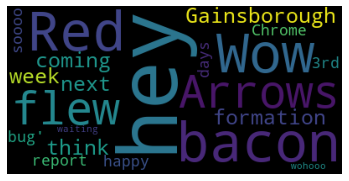

In [ ]:
positive =  df_train.loc[df_train['label'] == 4]
text = positive['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Get Word cloud with respect to the data for polarity = 0 which stands for negative**

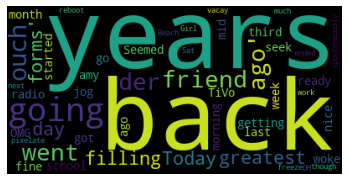

In [ ]:
negative =  df_train.loc[df_train['label'] == 0]
text = negative['text'].values 
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Loading the tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

**Load the train df to Arrow dataset**

Refer : https://huggingface.co/docs/datasets/v1.0.2/loading_datasets.html


* sampling the df_train to 80000 (Just to train the model quicker)
*   removing none values from the df
*   reset the index and remove the index from the df
*   Convert the df to arrow dataset
*   Change the feature of the dataset

The tokenized_text must have form of


**(0 = negative 4 = positive)**


```
{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0','4'], id=None)}
```







In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True,padding=True)

In [ ]:
df_train = df_train[:80000]
df_train =  df_train.dropna()
df_train.reset_index(drop=True, inplace=True)

# df_train to arrow dataset
dataset = Dataset.from_pandas(df_train)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2, names=['0','4'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

print(dataset.features)
tokenized_train = dataset.map(preprocess_function, batched=True)

{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/8 [00:00<?, ?ba/s]

{'label': ClassLabel(names=['0', '4'], id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
tokenized_train.features

{'label': ClassLabel(names=['0', '4'], id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**Trimming test data to 10000**

In [ ]:
df_test = df_test[:10000]
df_test =  df_test.dropna()
df_test.reset_index(drop=True, inplace=True)

# df_test to arrow dataset
dataset = Dataset.from_pandas(df_test)
print(dataset.features)

# change the feature of the dataset
features = dataset.features.copy()
# 0 stand for negative and 1 stands for positive
features["label"] = ClassLabel(num_classes=2,  names=['0','4'])
def adjust_labels(batch):
    batch["label"] = [str(sentiment) for sentiment in batch["label"]]
    return batch
dataset = dataset.map(adjust_labels, batched=True, features=features)

tokenized_test = dataset.map(preprocess_function, batched=True)

{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None)}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_test.features

{'label': ClassLabel(names=['0', '4'], id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

**To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors and concatenate them with the correct amount of padding**

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# **Define a Model**

DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. 

Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%.

https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model

distilbert-base-uncased

https://huggingface.co/distilbert-base-uncased



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

In [ ]:

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


training_args = TrainingArguments(
   output_dir="/content/model/",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
     

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 66955010


Step,Training Loss


KeyboardInterrupt: ignored

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 66955010


Step,Training Loss
500,0.254100
1000,0.259000


Saving model checkpoint to /content/model/checkpoint-500
Configuration saved in /content/model/checkpoint-500/config.json
Model weights saved in /content/model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/model/checkpoint-1000
Configuration saved in /content/model/checkpoint-1000/config.json
Model weights saved in /content/model/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/model/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/model/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=0.2565221557617188, metrics={'train_runtime': 147.988, 'train_samples_per_second': 108.117, 'train_steps_per_second': 6.757, 'total_flos': 412789112243136.0, 'train_loss': 0.2565221557617188, 'epoch': 2.0})

In [ ]:
trainer.evaluate(tokenized_train)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8000
  Batch size = 16


{'eval_loss': 0.2339109182357788,
 'eval_accuracy': 0.916375,
 'eval_f1': 0.9164898264885782,
 'eval_runtime': 16.5022,
 'eval_samples_per_second': 484.784,
 'eval_steps_per_second': 30.299,
 'epoch': 2.0}

In [ ]:
trainer.evaluate(tokenized_test)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'eval_loss': 0.45884257555007935,
 'eval_accuracy': 0.807,
 'eval_f1': 0.8163653663177926,
 'eval_runtime': 3.6389,
 'eval_samples_per_second': 274.806,
 'eval_steps_per_second': 17.313,
 'epoch': 2.0}

In [ ]:
trainer.save_model("/content/trained_model/")

Saving model checkpoint to /content/trained_model/
Configuration saved in /content/trained_model/config.json
Model weights saved in /content/trained_model/pytorch_model.bin
tokenizer config file saved in /content/trained_model/tokenizer_config.json
Special tokens file saved in /content/trained_model/special_tokens_map.json


In [ ]:
!zip -r trained.zip /content/trained_model/

In [ ]:
!cp trained.zip /content/drive/MyDrive/twitter/

In [ ]:
from transformers import TextClassificationPipeline

model = AutoModelForSequenceClassification.from_pretrained("/content/trained_model/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

In [ ]:
pipe("I just completed reading Whisper of the Evil Saints, a five-star book. I was smitten by the characters. I was looking for a typical romance book, but I ended up finding one of my all-time favourite books. I was stunned right when I believed I could foresee the result! Since the writing was so vivid, I felt as though I was there with the characters rather than just reading about them from a distance when Julia's heart broke. This is a must-read if romance books are your thing. Don't be fooled by the cover—this book is amazing!")
# (0 = negative, 1= positive)

[[{'label': 'LABEL_0', 'score': 0.1510315090417862},
  {'label': 'LABEL_1', 'score': 0.848968505859375}]]

In [ ]:
pipe("horrible beyond words! To prevent others from squandering their money, I feel compelled to write. This novel appears to have been authored by a seventh-grader who uses inappropriate grammar for her age. There is a mistake on the cover, as another reviewer has noted, and I think there is at least one in each chapter. For instance, she had a 'lean' on her house, which was mentioned twice. I chose to read with a pencil in hand to highlight all of the terrible grammar and spelling because the thin plot and poor writing were so distracting. Please don't throw away your cash. I also think that the author's family members must have written the favourable reviews. I will not put much faith")
# (0 = negative, 1= positive)

[[{'label': 'LABEL_0', 'score': 0.9307567477226257},
  {'label': 'LABEL_1', 'score': 0.06924330443143845}]]